# VAERS data reveals no increased risk of neuroautoimmune disorders from COVID-19 vaccines

## Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
from helpers.ingest_vaers import ingest
import warnings
from tqdm.notebook import tqdm
import re
import scipy.stats as stats

warnings.filterwarnings('ignore')

### Ingesting VAERS data

We use the helper functions in `helpers/ingest_vaers.py` to load VAERS data from the bulk download.

In [2]:
vaers_data = ingest(2021, 2020, 2019, 2018, 2017, 2016, 2015, path="data/")

#### Earliest and latest reports

In [3]:
print(f"Earliest report (date of receipt): {vaers_data['RECVDATE'].dropna().astype('datetime64[ns]').min()}")
print(f"Latest report (date of receipt): {vaers_data['RECVDATE'].dropna().astype('datetime64[ns]').max()}")

Earliest report (date of receipt): 2015-01-01 00:00:00
Latest report (date of receipt): 2021-05-28 00:00:00


#### Breakdown by vaccine type

In [4]:
counts = vaers_data.groupby("VAX_TYPE")["VAERS_ID"].count().rename({"columns": {"VAERS_ID": "Number of reports"}})
percentages = counts.div(counts.sum()) * 100

df = pd.concat([counts, percentages], axis=1)
df.columns = ["Number of reports", "Percentage of total"]
df.sort_values("Number of reports")

,Number of reports,Percentage of total
VAX_TYPE,,
PLAGUE,1,0.000040
ADEN,2,0.000079
MER,2,0.000079
TBE,3,0.000119
CEE,3,0.000119
...,...,...
FLU3,77097,3.048803
PPV,91058,3.600891
FLU4,107315,4.243775


Despite adducing five years' additional data, the COVID-19 vaccines are clearly overrepresented. The scale of the
COVID-19 vaccination effort, as well as the public attention, means that this will necessarily be the case. We can
compensate for this imbalance in the data set through high-level aggregation, which contrasts not individual vaccine
types but COVID-19 vaccines and everything else.

### Filtering VAERS data for key columns

We then filter the VAERS data for the columns that are going to form part of our analysis:

* `VAERS_ID` (unique report ID)
* `SYMPTOM` (name/description of symptom)
* `VAX_TYPE` (type/superclass of vaccine)
* `AGE_YRS` (age at vaccination, years)
* `SEX` (gender)

In [5]:
vaers_data = vaers_data[["VAERS_ID", "SYMPTOM", "VAX_TYPE", "AGE_YRS", "SEX"]]

### Categorising reports

We categorise reports according to two binary criteria:

* `IS_COVID_VACCINE`: whether the vaccine's superclass is `COVID19`
* `IS_NEUROAUTOIMMUNE`: whether the symptom is one of the symptoms listed in `NEUR_SYMPTOMS`

In [6]:
NEUR_SYMPTOMS = ("Demyelinating polyneuropathy",
                 "Immune-mediated neuropathy",
                 "Axonal neuropathy",
                 "Axonal and demyelinating neuropathy",
                 "Chronic inflammatory demyelinating polyradiculoneuropathy",
                 "Subacute inflammatory demyelinating polyradiculoneuropathy",
                 "Autoimmune neuropathy",
                 "Autonomic neuropathy",
                 "Guillain-Barre syndrome",
                 "Acute disseminated encephalomyelitis",
                 "Demyelinating polyneuropathy",
                 "Neuromyelitis optica spectrum disorder",
                 "Neuromyelitis optica",
                 "Myelitis transverse",
                 "Multiple sclerosis relapse",
                 "Multiple sclerosis",
                 "Relapsing multiple sclerosis",
                 "Progressive multiple sclerosis",
                 "Relapsing-remitting multiple sclerosis",
                 "Optic neuritis",
                 "Immune-mediated encephalitis",
                 "Autoimmune encephalopathy",
                 "Encephalitis autoimmune",
                 "Autoimmune demyelinating disease")

vaers_data["IS_COVID_VACCINE"] = (vaers_data.VAX_TYPE == "COVID19").astype(int)
vaers_data["IS_NEUROAUTOIMMUNE"] = vaers_data["SYMPTOM"].isin(NEUR_SYMPTOMS).astype(int)

## Age density distribution

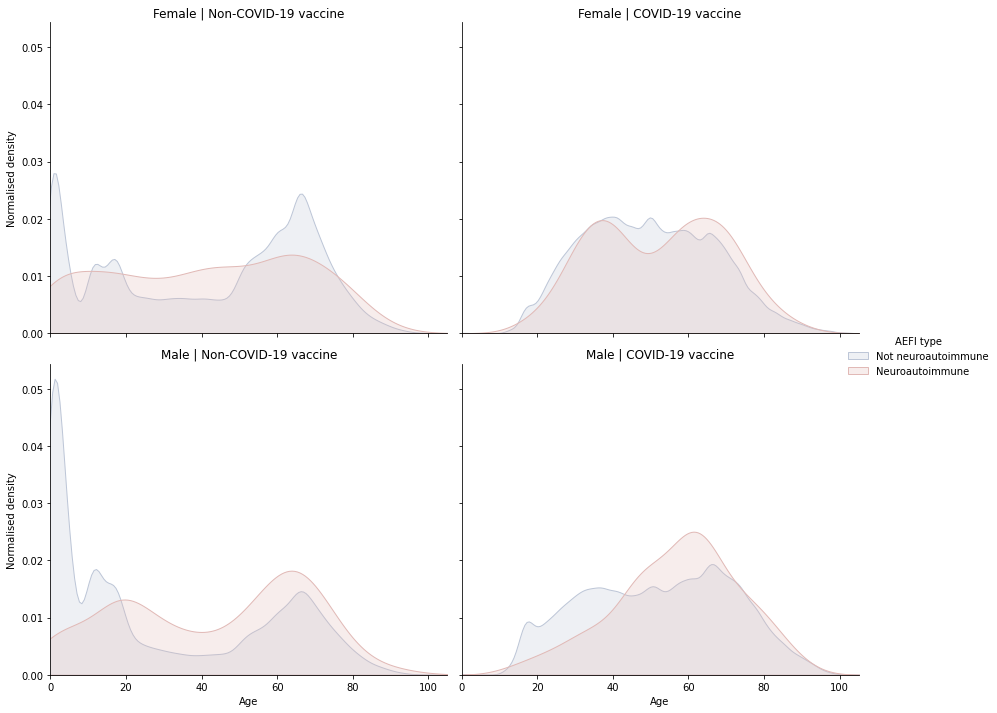

In [7]:
g = sns.FacetGrid(vaers_data[vaers_data.SEX.isin(("F", "M"))],
                  col="IS_COVID_VACCINE",
                  row="SEX",
                  hue="IS_NEUROAUTOIMMUNE",
                  height=5,
                  aspect=1.2,
                  palette="vlag")

g.map(sns.kdeplot, "AGE_YRS", fill=True)
g.set_axis_labels("", "")

g.add_legend()

# Custom legend labels
g._legend.set_title("AEFI type")
new_labels = ("Not neuroautoimmune", "Neuroautoimmune")
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Custom grid labels
axes = g.axes.flatten()
axes[0].set_title("Female | Non-COVID-19 vaccine")
axes[1].set_title("Female | COVID-19 vaccine")
axes[2].set_title("Male | Non-COVID-19 vaccine")
axes[3].set_title("Male | COVID-19 vaccine")

axes[0].set(xlim=(0, 105))
axes[1].set(xlim=(0, 105))
axes[2].set(xlim=(0, 105))
axes[3].set(xlim=(0, 105))

g.set_axis_labels("Age", "Normalised density")

g.savefig("writeup/age_distribution.pdf")

# Reporting Odds Ratio (ROR) analysis

## Contingency table: COVID-19 vs non-COVID-19 vaccines


In [8]:
xt = pd.crosstab(vaers_data.IS_COVID_VACCINE, vaers_data.IS_NEUROAUTOIMMUNE)

_d = xt.rename(index={0: "Non-COVID-19 vaccine", 1: "COVID-19 vaccine"},
               columns={0: "Non-neuroautoimmune AEFI", 1: "Neuroautoimmune AEFI"})

table = sm.stats.Table(_d.loc[:, ["Non-neuroautoimmune AEFI", "Neuroautoimmune AEFI"]])
table.table_orig

IS_NEUROAUTOIMMUNE,Non-neuroautoimmune AEFI,Neuroautoimmune AEFI
IS_COVID_VACCINE,,
Non-COVID-19 vaccine,1203677,1908
COVID-19 vaccine,1322566,612


### Fitted expectation values

The fitted expectation values use Pearson's $\chi^2$ metric to determine an expectation value, i.e. what number of a
particular AEFI or class of AEFIs were to be expected if the null hypothesis ($H_0$) is true, i.e. there
there is no association (positive or negative) between COVID-19 vaccines and neuroautoimmune AEFIs.

In [9]:
table.fittedvalues

IS_NEUROAUTOIMMUNE,Non-neuroautoimmune AEFI,Neuroautoimmune AEFI
IS_COVID_VACCINE,,
Non-COVID-19 vaccine,1.204384e+06,1201.407249
COVID-19 vaccine,1.321859e+06,1318.592751


### Pearson residuals

The Pearson residuals show the residuals from the $\chi^2$ metric. A negative Pearson residual means that there are
fewer actual cases than would be expected if $H_0$ were true, while a positive Pearson residual indicates that there
were more actual cases than would be expected if $H_0$ were true.

In [10]:
table.resid_pearson

IS_NEUROAUTOIMMUNE,Non-neuroautoimmune AEFI,Neuroautoimmune AEFI
IS_COVID_VACCINE,,
Non-COVID-19 vaccine,-0.643853,20.385626
COVID-19 vaccine,0.614577,-19.458701


These residuals indicate that reports off neuroautoimmune AEFIs are significantly lower for COVID-19 vaccines than
one would expect under the null hypothesis. Consequently, not only is there a strong association between COVID-19
versus non-COVID-19 vaccines and the development of neuroautoimmune AEFIs, but the correlation also shows that such
AEFIs are significantly less frequent for COVID-19 vaccines.

### Fisher's exact test

In [11]:
odds_ratio, p_value = stats.fisher_exact(xt)

print(xt)
print(f"Reporting odds ratio for association (Fisher's exact test): {odds_ratio} (p-value: {p_value})")

IS_NEUROAUTOIMMUNE        0     1
IS_COVID_VACCINE                 
0                   1203677  1908
1                   1322566   612
Reporting odds ratio for association (Fisher's exact test): 0.29192121638670443 (p-value: 1.7957717301608325e-181)


Fisher's exact tests of association shows that the odds ratio for neuroautoimmune AEFIs with COVID-19 vaccines is
0.2919 at a p-value < 0.0001. Thus, there is a highly statistically significant correlation here – neuroautoimmune
AEFIs are, in relation to other AEFIs, much less frequent with COVID-19 vaccines.

## Individual neuroautoimmune AEFIs' association

We now turn our attention to the association between individual AEFIs in the neuroautoimmune group, and their
expected vs. actual reporting ratios in VAERS.

In [12]:
tab = sm.stats.Table(pd.crosstab(vaers_data.IS_COVID_VACCINE, vaers_data.SYMPTOM).rename(
    index={0: "Non-COVID-19 vaccine", 1: "COVID-19 vaccine"})
                     )

pearson_residuals = tab.resid_pearson.T
actuals = tab.table_orig.T
expected = tab.fittedvalues.T

In [13]:
pearson_residuals["IS_NEUROAUTOIMMUNE"] = pearson_residuals.index.isin(NEUR_SYMPTOMS)
expected_versus_actual = \
    pearson_residuals[pearson_residuals.IS_NEUROAUTOIMMUNE == True].sort_values("COVID-19 vaccine").join(
        expected[["COVID-19 vaccine"]], how="left", rsuffix="_expected").join(
            actuals[["COVID-19 vaccine"]], how="left", rsuffix="_actual")[["COVID-19 vaccine_expected", "COVID-19 vaccine_actual"]]

expected_versus_actual["SYMPTOM"] = expected_versus_actual.index

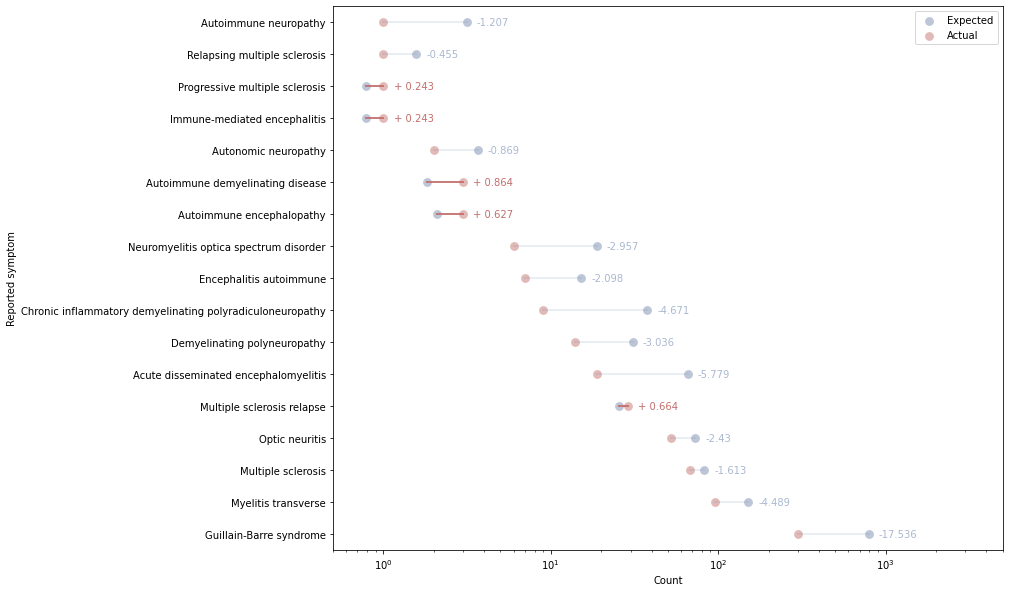

In [14]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set_xscale("log")

data = expected_versus_actual[expected_versus_actual["COVID-19 vaccine_actual"] > 0]
sort_order = list(data["COVID-19 vaccine_actual"].sort_values().index)
data["more_than_expected"] = data["COVID-19 vaccine_actual"] > data["COVID-19 vaccine_expected"]

for idx, val in enumerate(sort_order):
    if data.loc[val, "more_than_expected"]:
        plt.plot([data.loc[val, "COVID-19 vaccine_actual"], data.loc[val, "COVID-19 vaccine_expected"]], [idx, idx],
                 linewidth=2, alpha=0.9, color=sns.color_palette("vlag")[-1])
    else:
        plt.plot([data.loc[val, "COVID-19 vaccine_actual"], data.loc[val, "COVID-19 vaccine_expected"]], [idx, idx],
                 linewidth=2, alpha=0.15, color=sns.color_palette("vlag")[0])

grid = sns.pointplot(x="count",
                     y="SYMPTOM",
                     hue="IS_COVID_VACCINE",
                     join=False,
                     jitter=False,
                     data=data.melt(id_vars=["SYMPTOM", "more_than_expected"], value_name="count"),
                     palette="vlag",
                     order=sort_order)

for idx, val in enumerate(sort_order):
    if data.loc[val, "more_than_expected"]:
        plt.text(data.loc[val, "COVID-19 vaccine_actual"] * 1.15, idx + 0.1,
                 f"+ {round(pearson_residuals.loc[val, 'COVID-19 vaccine'], 3)}", color=sns.color_palette("vlag")[-1])
    else:
        plt.text(data.loc[val, "COVID-19 vaccine_expected"] * 1.15, idx + 0.1,
                 f"{round(pearson_residuals.loc[val, 'COVID-19 vaccine'], 3)}", color=sns.color_palette("vlag")[1])

axes = grid.set(xlim=(5e-1, 5e3), xlabel="Count", ylabel="Reported symptom")

handles, labels = ax.get_legend_handles_labels()
grid.legend(handles=handles, labels=("Expected", "Actual"))

grid.figure.savefig("writeup/expected_vs_actual_by_symptoms.pdf")

While there seem to be much fewer cases of neuroautoimmune AEFIs following COVID-19 vaccination than with other
vaccines, there appears to be a small excess in

* MS relapses (Pearson residual: 0.664),
* autoimmune encephalopathy (Pearson residual: 0.627) and
* autoimmune demyelinating disease (Pearson residual: 0.864).

Although this data alone is not suggestive of an association or a causal effect, it suggests that patients with a known
demyelinating disease like MS be monitored for signs of relapse/progression, and where patients present with
novel neurological signs suggestive of CNS demyelination or autoimmune encephalitis (e.g. seizures, new onset of
psychosis in adulthood, involuntary movements, delusions/hallucinations) following COVID-19 vaccination, these be given
consideration in the wider clinical context as part of the differential diagnosis.

It is important to underline that this data does not sufficiently suggest a strong association and does not suggest a
causal link at all between these conditions and the COVID-19 vaccine – indeed, the fact that these conditions are
relatively rare and that the COVID-19 vaccine is associated with much lower incidence of all other neuroautoimmune AEFIs,
suggests that this indication may be attributable to noise, reporting bias and the widespread nature of COVID-19
vaccines.

## Reporting odds ratios of neuroautoimmune AEFIs in comparison to other vaccines

### Filter for relevant symptoms

We use a series of regular expressions (regex) to filter out a range of recorded symptoms that do not constitute an
indication of an AEFI:

* normal results
* records of tests conducted without results
* procedures, incl. diagnostic and surgical interventions
* care and management activities
* immunisation and vaccination
* patient status indicators (e.g. drug or tobacco use status)

Because some symptoms are ambiguous (a reporter may select one of the allergy entries to note both a pre-existing
allergy and one that the patient developed after the vaccination), this selection does not eliminate every possible \
non-AEFI, but reduces the noise in the data set from irrelevant data points.

In [15]:
p_normals = r".*negative$|.*\snormal$|.*(scopy|graphy|gram|metry|opsy)$|.*(count|percentage|level|test|assay|culture|X-ray|imaging|gradient|band(s)?|index|surface area|gas|scale|antibod(y|ies)|urine absent|Carotid pulse|partial pressure|time|P(C)?O2)$|Oxygen saturation$|End-tidal.*"
p_tests = r".*(ase|ose|ine|enzyme|in|ine|ines|ium|ol|ole|ate|lytes|ogen|gases|oids|ide|one|an|copper|iron)$|.*(level therapeutic)$|.*(globulin)\s.{1,2}$|Barium (swallow|enema)"
p_procedures = r".*(plasty|insertion|tomy|ery|puncture|therapy|treatment|tripsy|operation|repair|procedure|bypass|insertion|removal|graft|closure|implant|lavage|support|transplant|match|bridement|application|ablation)$|Incisional drainage$|.* stimulation$|Immunisation$"
p_normal_procedures = r"(Biopsy|pH|.* examination|X-ray|.* pulse|Blood|Electro(.*)gram|.* test(s)?|Echo(.*)gram|.*(scopy)|Cardiac (imaging|monitoring|ventriculogram)|Chromosomal|Carbohydrate antigen|Cell marker|.* examination|Computerised tomogram|Culture|.* evoked potential(s)?|Cytology|Doppler)(?!.*(abnormal|increased|decreased|depression|elevation|present|absent))"
p_managements = r"(Catheter|Device\).*|.* care$|.* user$|Cardiac pacemaker .*"
p_other_irrelevants = r"Blood group.*|Blood don(or|ation)$|Drug (abuse(r)?|dependence|screen).*|Elderly|Non-tobacco user|No adverse event"
p_covid_related = r".*COVID-19(prophylaxis|immunisation|screening)|Asymptomatic COVID-19"

p = re.compile("|".join([p_normals, p_tests, p_procedures, p_normal_procedures, p_other_irrelevants, p_covid_related]))

In [16]:
xt_by_symptom = pd.crosstab(vaers_data.VAX_TYPE, vaers_data.SYMPTOM)
columns_to_keep = [x for x in list(xt_by_symptom.columns) if not p.match(x)]
xt_by_symptom = xt_by_symptom[columns_to_keep]

### Creating symptom-level ROR tables

In this step, we calculate the ROR for every symptom by every vaccine.

In [17]:
odds_ratios_by_symptom = pd.DataFrame(columns=xt_by_symptom.columns,
                                      index=xt_by_symptom.index)

symptom_sums = xt_by_symptom.sum(axis=0)
vax_sums = xt_by_symptom.sum(axis=1)
xt_by_symptom_total = xt_by_symptom.sum().sum()

vax_iterator = tqdm(xt_by_symptom.index)

for vaccine in vax_iterator:
    vax_iterator.set_description(f"Processing: {vaccine}")
    for symptom in xt_by_symptom.columns:
        a = xt_by_symptom.loc[vaccine, xt_by_symptom.columns == symptom].sum()
        b = vax_sums[vaccine] - a
        c = symptom_sums[symptom] - a
        d = xt_by_symptom_total - a - b - c

        OR = (a * d) / (c * b) if c * b > 0 else np.nan
        odds_ratios_by_symptom.loc[vaccine, symptom] = OR

  0%|          | 0/92 [00:00<?, ?it/s]

In [18]:
odds_ratios_by_symptom.to_csv("odds_ratios_by_symptom.csv")

### Plot RORs for each vaccine type

In [19]:
odds_ratios_by_symptom["VACCINE_TYPE"] = odds_ratios_by_symptom.index
odds_ratios_melted = odds_ratios_by_symptom.melt(id_vars="VACCINE_TYPE", value_name="OR")
odds_ratios_melted["IS_NEUROAUTOIMMUNE"] = odds_ratios_melted["SYMPTOM"].isin(NEUR_SYMPTOMS)

In [20]:
SHOW_VACCINES = ("COVID19", "MENB", "HPV4", "HPV9", "FLU3", "FLU4", "HEP", "VARZOS", "PNC13", "HEPAB")

odds_ratios_melted = odds_ratios_melted[
    (odds_ratios_melted.VACCINE_TYPE.isin(SHOW_VACCINES) & (odds_ratios_melted.IS_NEUROAUTOIMMUNE == True))]

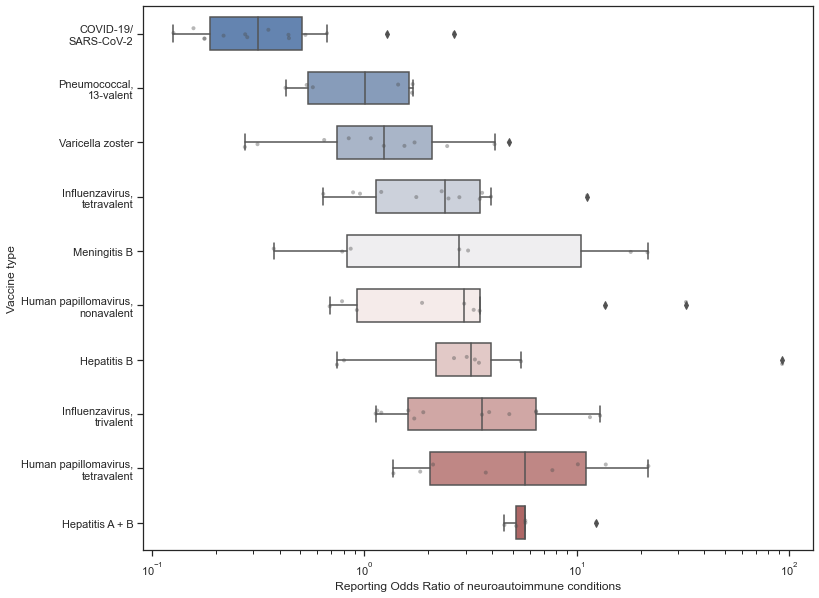

In [21]:
sns.set_theme(style="ticks")

vaccine_type_names = {"COVID19": "COVID-19/\nSARS-CoV-2",
                      "PNC13": "Pneumococcal,\n13-valent",
                      "VARZOS": "Varicella zoster",
                      "FLU4": "Influenzavirus,\ntetravalent",
                      "MENB": "Meningitis B",
                      "HPV9": "Human papillomavirus,\nnonavalent",
                      "HEP": "Hepatitis B",
                      "FLU3": "Influenzavirus,\ntrivalent",
                      "HPV4": "Human papillomavirus,\ntetravalent",
                      "HEPAB": "Hepatitis A + B"}

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(12, 10))
ax.set_xscale("log")

# Create ordering

order_by_mean_OR = odds_ratios_melted.replace(0, np.nan).replace({"VACCINE_TYPE": vaccine_type_names}).groupby(by=["VACCINE_TYPE"])[
    "OR"].median().sort_values(ascending=False).iloc[::-1].index

# Initialize the figure with a logarithmic x axis

sns.boxplot(data=odds_ratios_melted.replace(0, np.nan).replace({"VACCINE_TYPE": vaccine_type_names}),
            y="VACCINE_TYPE",
            x="OR",
            palette="vlag",
            width=.6,
            order=order_by_mean_OR)

sns.stripplot(data=odds_ratios_melted.replace(0, np.nan).replace({"VACCINE_TYPE": vaccine_type_names}),
              y="VACCINE_TYPE",
              x="OR",
              size=4,
              color=".3",
              alpha=0.4,
              linewidth=0,
              order=order_by_mean_OR)

plt.xlabel("Reporting Odds Ratio of neuroautoimmune conditions")
plt.ylabel("Vaccine type")

plt.savefig("ror_by_vaccine_type.pdf")

As this indicates, the ROR of neuroautoimmune AEFIs is the lowest for the COVID-19 vaccine among all vaccines in the
selection.